In [18]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import levene
from scipy.stats import ttest_ind

Definition of confounding variable: (1) they affect the dependent variable and (2) the groups differ on the confounding variable.$\newline$, (3) They cannot be part of causal link between Dependent and Indepoendent

We take confounds as attributes of professors that would impact a students ability to rate them honestly

Analysis Plan:$\newline$

Step 1) Test wether or not there is a significant difference in the two groups without controlling for potential confounds.$\newline$

Step 2) Check for potential confounding variables. We use significance testing and correlation tests to see if 1) the there is a correlation between the potential confound and the dependent variable, and 2), to see if there is a correlation between the potential confound and the idependent variable.$\newline$

Step 3) If not a confound, we forget about it and start over.$\newline$

Step 4) If it is a confound, we will control for it using stratification and see what has changed between the relationship between the independent variable and the dependent variable.$\newline$

NOTE: To avoid Type 1 errors, we set alpha = .005. Also, to avoid p-hacking, we stick with a plan to divide subgroups for stratification within each question and use the same grouping throughout the problem. We will use the median split for this problem.

In [4]:
'''
Columns are:
1. Average Rating (the arithmetic mean of all individual quality ratings of this professor)
2. Average Difficulty (the arithmetic mean of all individual difficulty ratings of this professor)
3. Number of ratings (simply the total number of ratings these averages are based on)
4. Received a “pepper”? (Boolean - was this professor judged as “hot” by the students?)
5. The proportion of students that said they would take the class again
6. The number of ratings coming from online classes
7. Male gender (Boolean – 1: determined with high confidence that professor is male)
8. Female (Boolean – 1: determined with high confidence that professor is female)
'''
numDat = pd.read_csv('rmpCapstoneNum.csv', header=None)
numDat.columns = ['Average Rating', 'Average Difficulty', 'Number of ratings', 'Received a pepper', 
                       'Proportion of students that said they would take the class again', 
                       'Number of ratings coming from online classes', 'Male Professor', 'Female Professor']

5) Is there a gender difference in terms of average difficulty? Again, a significance test is indicated.

6) Please quantify the likely size of this effect at 95% confidence.

In [5]:
# Keep rows where 'Number of ratings' is greater or equal to 10
numDat = numDat.loc[numDat['Number of ratings'] >= 10]

# Remove rows where 'Male Professor' and 'Female Professor' are both 0 or both 1
numDat = numDat.loc[
    ~((numDat['Male Professor'] == 0) & (numDat['Female Professor'] == 0)) &
    ~((numDat['Male Professor'] == 1) & (numDat['Female Professor'] == 1))
]

# Display the final filtered dataset
numDat

,Average Rating,Average Difficulty,Number of ratings,Received a pepper,Proportion of students that said they would take the class again,Number of ratings coming from online classes,Male Professor,Female Professor
5,3.5,3.3,22.0,0.0,56.0,7.0,1,0
21,2.6,4.1,10.0,0.0,NaN,0.0,1,0
25,4.3,3.3,16.0,1.0,83.0,0.0,0,1
39,3.5,3.2,20.0,1.0,NaN,0.0,1,0
40,1.8,3.8,15.0,0.0,22.0,1.0,0,1
...,...,...,...,...,...,...,...,...
89810,3.4,3.4,14.0,0.0,54.0,5.0,1,0
89841,4.2,3.8,11.0,0.0,NaN,0.0,0,1
89855,4.0,1.9,11.0,1.0,60.0,0.0,1,0
89866,4.4,3.6,14.0,1.0,88.0,0.0,0,1


First Visualize Distributions of Both

In [14]:
numDat_Avg_Diff_Male = numDat[numDat['Male Professor']==1]
numDat_Avg_Diff_Female = numDat[numDat['Female Professor']==1]

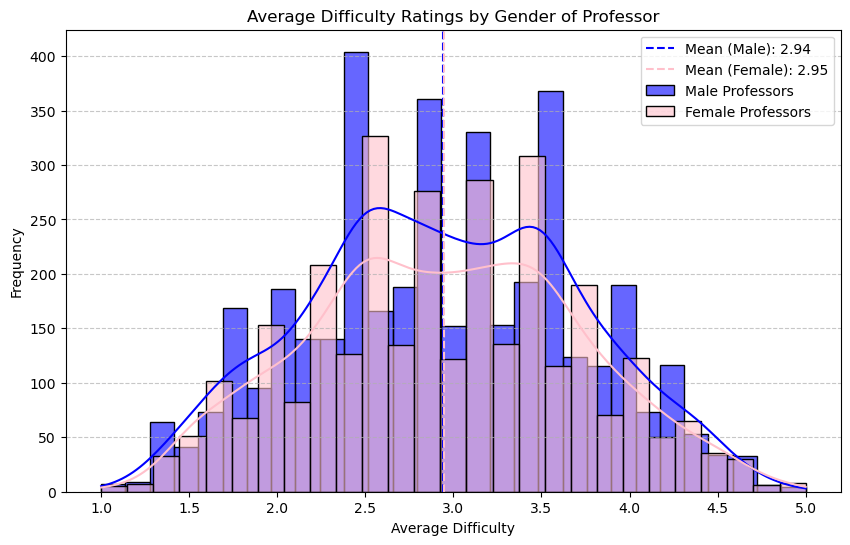

In [15]:
# Create the plot
plt.figure(figsize=(10, 6))

# Male professors' histogram and KDE
sns.histplot(
    numDat_Avg_Diff_Male['Average Difficulty'], 
    kde=True, 
    color='blue', 
    label='Male Professors', 
    alpha=0.6
)
mean_male = numDat_Avg_Diff_Male['Average Difficulty'].mean()
plt.axvline(mean_male, color='blue', linestyle='--', label=f'Mean (Male): {mean_male:.2f}')

# Female professors' histogram and KDE
sns.histplot(
    numDat_Avg_Diff_Female['Average Difficulty'], 
    kde=True, 
    color='pink', 
    label='Female Professors', 
    alpha=0.6
)
mean_female = numDat_Avg_Diff_Female['Average Difficulty'].mean()
plt.axvline(mean_female, color='pink', linestyle='--', label=f'Mean (Female): {mean_female:.2f}')

# Customize the plot
plt.title('Average Difficulty Ratings by Gender of Professor')
plt.xlabel('Average Difficulty')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


In [16]:
# Compute variance for male professors
variance_male = numDat_Avg_Diff_Male['Average Difficulty'].var()

# Compute variance for female professors
variance_female = numDat_Avg_Diff_Female['Average Difficulty'].var()

# Display results
print(f"Variance of Average Difficulty (Male Professors): {variance_male:.3f}")
print(f"Variance of Average Difficulty (Female Professors): {variance_female:.3f}")

Variance of Average Difficulty (Male Professors): 0.592
Variance of Average Difficulty (Female Professors): 0.587


In [62]:
from scipy.stats import mannwhitneyu, ks_2samp
import numpy as np

# Function to calculate the effect size (rank-biserial correlation)
def rank_biserial_effect_size(u_stat, group1, group2):
    n1, n2 = len(group1), len(group2)
    return (2 * u_stat) / (n1 * n2) - 1

# Function to calculate bootstrap confidence intervals for the effect size
def bootstrap_effect_size_ci(group1, group2, num_bootstrap=1000, alpha=0.05):
    bootstrapped_effect_sizes = []
    for _ in range(num_bootstrap):
        group1_sample = np.random.choice(group1, size=len(group1), replace=True)
        group2_sample = np.random.choice(group2, size=len(group2), replace=True)
        u_stat_sample, _ = mannwhitneyu(group1_sample, group2_sample, alternative='two-sided')
        effect_size_sample = rank_biserial_effect_size(u_stat_sample, group1_sample, group2_sample)
        bootstrapped_effect_sizes.append(effect_size_sample)
    lower = np.percentile(bootstrapped_effect_sizes, 100 * (alpha / 2))
    upper = np.percentile(bootstrapped_effect_sizes, 100 * (1 - alpha / 2))
    return lower, upper

# Filter for male and female professor difficulty ratings
male_difficulty = numDat[numDat['Male Professor'] == 1]['Average Difficulty'].to_numpy()
female_difficulty = numDat[numDat['Female Professor'] == 1]['Average Difficulty'].to_numpy()

# Mann-Whitney U Test
u_stat, p_value_mw = mannwhitneyu(male_difficulty, female_difficulty, alternative='two-sided')

# Kolmogorov-Smirnov Test
ks_stat, p_value_ks = ks_2samp(male_difficulty, female_difficulty)

# Calculate effect size for Mann-Whitney U
effect_size_mw = rank_biserial_effect_size(u_stat, male_difficulty, female_difficulty)

# Bootstrap confidence interval for effect size
ci_lower, ci_upper = bootstrap_effect_size_ci(male_difficulty, female_difficulty)

# Display results
print("Mann-Whitney U Test:")
print(f"  U-Statistic: {u_stat:.3f}")
print(f"  P-Value: {p_value_mw:.3f}")
print(f"  Effect Size (Rank-Biserial Correlation): {effect_size_mw:.3f}")
print(f"  95% Bootstrap CI for Effect Size: ({ci_lower:.3f}, {ci_upper:.3f})")
if p_value_mw < 0.005:
    print("  The distributions of average difficulty ratings significantly differ between male and female professors.")
else:
    print("  The distributions of average difficulty ratings do not significantly differ between male and female professors.")

print("\nKolmogorov-Smirnov Test:")
print(f"  KS-Statistic: {ks_stat:.3f}")
print(f"  P-Value: {p_value_ks:.3f}")
if p_value_ks < 0.005:
    print("  The distributions of average difficulty ratings significantly differ between male and female professors.")
else:
    print("  The distributions of average difficulty ratings do not significantly differ between male and female professors.")


Mann-Whitney U Test:
  U-Statistic: 6192402.000
  P-Value: 0.786
  Effect Size (Rank-Biserial Correlation): -0.004
  95% Bootstrap CI for Effect Size: (-0.031, 0.025)
  The distributions of average difficulty ratings do not significantly differ between male and female professors.

Kolmogorov-Smirnov Test:
  KS-Statistic: 0.009
  P-Value: 0.997
  The distributions of average difficulty ratings do not significantly differ between male and female professors.


In [53]:
len(male_difficulty)

3987

In [54]:
len(female_difficulty)

3118

Power = .007

Testing Number of Ratings (proxy for experience) as a confound

In [40]:
# Calculate the Pearson correlation between Average Rating and Average Difficulty
correlation = numDat[['Number of ratings', 'Average Difficulty']].corr().iloc[0, 1]

# Display the result
print(f"The correlation between Number of rating and Average Difficulty is: {correlation:.3f}")

The correlation between Number of rating and Average Difficulty is: 0.008


In [43]:
from scipy.stats import ks_2samp

# Step 1: Calculate the median of 'Number of ratings'
median_ratings = numDat['Number of ratings'].median()

# Step 2: Split 'Average Difficulty' into two groups based on the median of 'Number of ratings'
below_median_difficulty = numDat[numDat['Number of ratings'] <= median_ratings]['Average Difficulty']
above_median_difficulty = numDat[numDat['Number of ratings'] > median_ratings]['Average Difficulty']

# Step 3: Perform KS test to compare distributions
ks_stat, p_value = ks_2samp(below_median_difficulty, above_median_difficulty)

# Display results
print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpretation
if p_value < 0.005:  # Assuming a significance level of 0.005
    print("The distribution of Average Difficulty significantly changes based on the Number of ratings.")
else:
    print("The distribution of Average Difficulty does not significantly change based on the Number of ratings.")



Kolmogorov-Smirnov Statistic: 0.034
P-value: 0.030
The distribution of Average Difficulty does not significantly change based on the Number of ratings.


Number of rating is not a confound for average difficulty.

Testing Average Rating as a confound

In [47]:
from scipy.stats import ks_2samp

# Step 1: Calculate the median of 'Number of ratings'
median_ratings = numDat['Average Rating'].median()

# Step 2: Split 'Average Difficulty' into two groups based on the median of 'Number of ratings'
below_median_difficulty = numDat[numDat['Average Rating'] <= median_ratings]['Average Difficulty']
above_median_difficulty = numDat[numDat['Average Rating'] > median_ratings]['Average Difficulty']

# Step 3: Perform KS test to compare distributions
ks_stat, p_value = ks_2samp(below_median_difficulty, above_median_difficulty)

# Display results
print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpretation
if p_value < 0.005:  # Assuming a significance level of 0.005
    print("The distribution of Average Difficulty significantly changes based on Average ratings.")
else:
    print("The distribution of Average Difficulty does not significantly change based on Average ratings.")

Kolmogorov-Smirnov Statistic: 0.470
P-value: 0.000
The distribution of Average Difficulty significantly changes based on Average ratings.


In [45]:
# Calculate the Pearson correlation between Average Rating and Average Difficulty
correlation = numDat[['Average Rating', 'Average Difficulty']].corr().iloc[0, 1]

# Display the result
print(f"The correlation between Average Rating and Average Difficulty is: {correlation:.3f}")


The correlation between Average Rating and Average Difficulty is: -0.651


Average Rating will be treated as a confound.

Received a peper

In [44]:
# Compute the Pearson correlation between 'Received a Pepper' and 'Average Difficulty'
correlation = numDat[['Received a pepper', 'Average Difficulty']].corr().iloc[0, 1]

# Display the result
print(f"The correlation between 'Received a Pepper' and 'Average Difficulty' is: {correlation:.3f}")


The correlation between 'Received a Pepper' and 'Average Difficulty' is: -0.290


In [63]:
from scipy.stats import mannwhitneyu, ks_2samp

# Filter for Average Difficulty based on 'Received a pepper'
pepper_group = numDat[numDat['Received a pepper'] == 1]['Average Difficulty']
no_pepper_group = numDat[numDat['Received a pepper'] == 0]['Average Difficulty']

# Mann-Whitney U Test
u_stat, p_value_mw = mannwhitneyu(pepper_group, no_pepper_group, alternative='two-sided')

# Kolmogorov-Smirnov Test
ks_stat, p_value_ks = ks_2samp(pepper_group, no_pepper_group)

# Display results
print("Mann-Whitney U Test:")
print(f"  U-Statistic: {u_stat:.3f}")
print(f"  P-Value: {p_value_mw:.3f}")
if p_value_mw < 0.005:
    print("  The distributions of Average Difficulty significantly differ between professors who received a pepper and those who did not.")
else:
    print("  The distributions of Average Difficulty do not significantly differ between professors who received a pepper and those who did not.")

print("\nKolmogorov-Smirnov Test:")
print(f"  KS-Statistic: {ks_stat:.3f}")
print(f"  P-Value: {p_value_ks:.3f}")
if p_value_ks < 0.005:
    print("  The distributions of Average Difficulty significantly differ between professors who received a pepper and those who did not.")
else:
    print("  The distributions of Average Difficulty do not significantly differ between professors who received a pepper and those who did not.")


Mann-Whitney U Test:
  U-Statistic: 4197152.000
  P-Value: 0.000
  The distributions of Average Difficulty significantly differ between professors who received a pepper and those who did not.

Kolmogorov-Smirnov Test:
  KS-Statistic: 0.269
  P-Value: 0.000
  The distributions of Average Difficulty significantly differ between professors who received a pepper and those who did not.


In [25]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(numDat['Male Professor'], numDat['Received a pepper'])

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the results
print("Contingency Table:")
print(contingency_table)
print(f"\nChi-Square Statistic: {chi2:.3f}")
print(f"P-value: {p_value:.3f}")
print(f"Degrees of Freedom: {dof}")

Contingency Table:
Received a pepper   0.0   1.0
Male Professor               
0                  1528  1590
1                  2064  1923

Chi-Square Statistic: 5.232
P-value: 0.022
Degrees of Freedom: 1


In [56]:
from scipy.stats import mannwhitneyu

# Filter data for male and female professors
male_pepper = numDat[numDat['Male Professor'] == 1]['Received a pepper']
female_pepper = numDat[numDat['Male Professor'] == 0]['Received a pepper']

# Perform Mann-Whitney U test
u_stat, p_value = mannwhitneyu(male_pepper, female_pepper, alternative='two-sided')

# Display results
print(f"Mann-Whitney U Statistic: {u_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpretation
if p_value < 0.005:  # Assuming a significance level of 0.005
    print("The distributions of 'Received a pepper' significantly differ between male and female professors.")
else:
    print("The distributions of 'Received a pepper' do not significantly differ between male and female professors.")


Mann-Whitney U Statistic: 6044025.000
P-value: 0.021
The distributions of 'Received a pepper' do not significantly differ between male and female professors.


In [59]:
import numpy as np
from scipy.stats import mannwhitneyu, ks_2samp

# Iterate over conditions and perform tests
print("Mann-Whitney U Test and Kolmogorov-Smirnov Test Results:")
for pepper_status in [0, 1]:  # 0 = No Pepper, 1 = Pepper
    # Filter male and female groups for the current pepper status
    males = numDat[(numDat['Male Professor'] == 1) &
                   (numDat['Received a pepper'] == pepper_status)]['Average Difficulty']
    
    females = numDat[(numDat['Male Professor'] == 0) &
                     (numDat['Received a pepper'] == pepper_status)]['Average Difficulty']
    
    # Check if both groups have enough data
    if len(males) > 1 and len(females) > 1:
        # Mann-Whitney U Test
        u_stat, p_value_mw = mannwhitneyu(males, females, alternative='two-sided')
        
        # Kolmogorov-Smirnov Test
        ks_stat, p_value_ks = ks_2samp(males, females)

        # Print results for this subgroup
        print(f"Group: Pepper = {'Yes' if pepper_status == 1 else 'No'}")
        print(f"  Mann-Whitney U Test Statistic: {u_stat:.3f}")
        print(f"  Mann-Whitney P-Value: {p_value_mw:.3f}")
        print(f"  {'Significant' if p_value_mw < 0.005 else 'Not Significant'}")
        print(f"  Kolmogorov-Smirnov Statistic: {ks_stat:.3f}")
        print(f"  Kolmogorov-Smirnov P-Value: {p_value_ks:.3f}")
        print(f"  {'Significant' if p_value_ks < 0.005 else 'Not Significant'}")
    else:
        # Print message if there is insufficient data
        print(f"Group: Pepper = {'Yes' if pepper_status == 1 else 'No'}")
        print("  Not enough data for Mann-Whitney U Test and Kolmogorov-Smirnov Test")


Mann-Whitney U Test and Kolmogorov-Smirnov Test Results:
Group: Pepper = No
  Mann-Whitney U Test Statistic: 1549350.500
  Mann-Whitney P-Value: 0.370
  Not Significant
  Kolmogorov-Smirnov Statistic: 0.033
  Kolmogorov-Smirnov P-Value: 0.296
  Not Significant
Group: Pepper = Yes
  Mann-Whitney U Test Statistic: 1509395.000
  Mann-Whitney P-Value: 0.517
  Not Significant
  Kolmogorov-Smirnov Statistic: 0.019
  Kolmogorov-Smirnov P-Value: 0.903
  Not Significant
